In [1]:
from scipy.spatial.distance import cdist
import commoncode as commoncode
import numpy as np
import matplotlib.pyplot as plt
import SkewGP as SkewGP
import GPy as GPy
from matplotlib import pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import norm
import pymc3 as pm


## We  generate some data

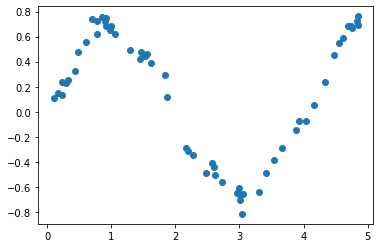

In [2]:
def fun(x,noise_std=0.1):
    v=(4*np.sin(x/2*np.pi)-0.5*np.sin(2*x*np.pi))/6+np.random.randn(len(x))*noise_std
    return v

σ = 0.05
np.random.seed(42)
x=np.random.rand(60)*5
y=fun(x,noise_std=σ)
plt.scatter(x,y)
X=x.reshape(-1,1)
Y=y.reshape(-1,1)
C=np.eye(Y.shape[0])

We define the Kernel and an empty skewness function for SkewGP. We are going to use  a zero dimension SkewGP, which is a GP prior and so we do not need Delta. In this case SkewGP regression coincides with GP regression.

In [6]:
def Kernel(X1,X2,params,diag_=False):
        lengthscale=params['lengthscale']['value']
        variance   =params['variance']['value']
        if diag_==False:
            diffs = cdist(np.atleast_2d(X1)/ lengthscale, np.atleast_2d(X2) / lengthscale, metric='sqeuclidean')
        else:
            diffs = np.sum((np.atleast_2d(X1)/ lengthscale-np.atleast_2d(X2)/ lengthscale)*(np.atleast_2d(X1)/ lengthscale-np.atleast_2d(X2)/ lengthscale),axis=1)
        return variance * np.exp(-0.5 * diffs)
    
def Delta(X,params):
    #empty
    return []

noise_variance = σ**2
logexp=commoncode.logexp()
latent_dim=0
params0={'lengthscale': {'value':np.array([1.0]), 
                    'range':np.vstack([[0.00001, 50.0]]),
                    'transform': logexp},
         'variance': {'value':np.array([1.0]), 
                    'range':np.vstack([[0.001, 100.0]]),
                    'transform': logexp},
         'noise_variance': {'value':np.array([1.0]), 
                    'range':np.vstack([[0.000001, 50.001]]),
                    'transform': logexp}
      }

model = SkewGP.SkewGP(X,Kernel, Delta, params0, C=C, Y=Y,  latent_dim =0, type_y='regression', jitter=1e-4)
#we optimize the hyperparameters
ml=model.optimize(max_iters=1000) 
print("Marginal Likelihood",ml)

Iteration 0  71.45355010268747
Marginal Likelihood 71.45355010268747


In [7]:
model.params


{'lengthscale': {'value': array([0.46128391]),
  'range': array([[1.e-05, 5.e+01]]),
  'transform': <commoncode.logexp at 0x7fb5ab714e20>},
 'variance': {'value': array([0.18358158]),
  'range': array([[1.e-03, 1.e+02]]),
  'transform': <commoncode.logexp at 0x7fb5ab714e20>},
 'noise_variance': {'value': array([0.00163838]),
  'range': array([[1.0000e-06, 5.0001e+01]]),
  'transform': <commoncode.logexp at 0x7fb5ab714e20>}}

In [8]:
Xpred=np.linspace(0,5.5,200)[:,None]
print(Xpred.shape)
predictions=model.predict(Xpred,nsamples=10000);

(200, 1)
Start Lin-Ess sampler
Progress: |██████████████████████████████████████████████████| 100.0% Complete


 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:337: UserWarning:hpd will be deprecated Please replace hdi
 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning:hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


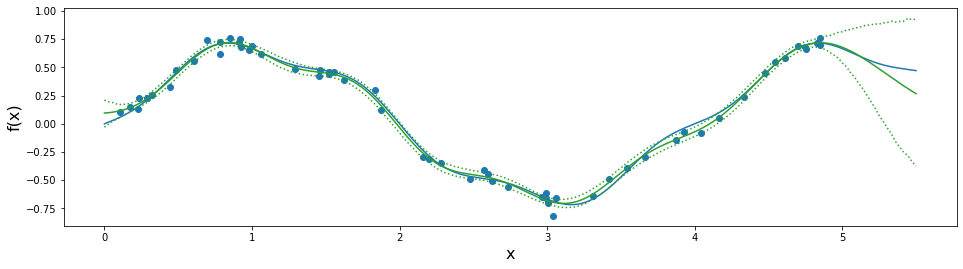

In [12]:
plt.figure(figsize=(16,4))
plt.scatter(x,y)
plt.plot(Xpred[:,0],fun(Xpred[:,0],noise_std=0))

#we compute the credible intervals
credib_int = pm.stats.hpd(predictions.T)
#we plot the latent function mean and credible interval
plt.plot(Xpred[:,0],credib_int[:,1],color='C2', linestyle=':')
plt.plot(Xpred[:,0],credib_int[:,0],color='C2', linestyle=':')
plt.plot(Xpred[:,0],np.mean(predictions,axis=1), label='mean',color='C2')
plt.xlabel("x",fontsize=16)
plt.ylabel("f(x)",fontsize=16);